# Attention Networks

The tutorial will cover the following:

* Preparing a simple dataset for time series forecasting
* How to use a network built via SimpleRNN for time series forecasting
* Adding a custom attention layer to the SimpleRNN network

In [1]:
from pandas import read_csv
import numpy as np
from keras import Model
from keras.layers import Layer
import keras.backend as K
from keras.layers import Input, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.metrics import mean_squared_error

### The Dataset

We will create a fibonacci sequence dataset for our purpose. In Fibonacci sequence, one number is constructed from the previous two numbers. The first 10 numbers of the sequence are shown below:

0, 1, 1, 2, 3, 5, 8, 13, 21, 34, …


When given the previous ‘t’ numbers, can you get a machine to accurately reconstruct the next number? This would mean discarding all the previous inputs except the last two and performing the correct operation on the last two numbers.

For this tutorial, you’ll construct the training examples from t time steps and use the value at t+1 as the target. For example, if t=3, then the training examples and the corresponding target values would look as follows:


In [2]:
# Prepare data
def get_fib_seq(n, scale_data=True):
    # Get the Fibonacci sequence
    seq = np.zeros(n)
    fib_n1 = 0.0
    fib_n = 1.0
    for i in range(n):
            #
            # Your code to create the fibonacci sequence. Store the sequence in an numpy array 'seq'
            #
        if i == 0:
          seq[i] = fib_n1
        elif i == 1:
          seq[i] = fib_n
        else:
          fib_next = fib_n1 + fib_n
          seq[i] = fib_next
          fib_n1 = fib_n
          fib_n = fib_next
    scaler = []
    if scale_data:
        scaler = MinMaxScaler(feature_range=(0, 1))
        seq = np.reshape(seq, (n, 1))
        seq = scaler.fit_transform(seq).flatten()
    return seq, scaler


In [3]:
#
# Check if the function works correctly.
#
seq, scaler = get_fib_seq(10)
print("Fibonacci sequence:", seq)

Fibonacci sequence: [0.         0.02941176 0.02941176 0.05882353 0.08823529 0.14705882
 0.23529412 0.38235294 0.61764706 1.        ]


In [4]:
def get_fib_XY(total_fib_numbers, time_steps, train_percent, scale_data=True):
    dat, scaler = get_fib_seq(total_fib_numbers, scale_data) ## Loading the dataset.

    #
    #
    # Your code to create training and test dataset.
    # Note - function argument total_fib_number is the total number of fibonacci numbers,
    # time_step is the length of the input,
    # and train_percent determines the ratio of train and test size
    #
    #
    # Create the X and Y datasets
    X, Y = [], []
    for i in range(len(dat) - time_steps):
        X.append(dat[i:i + time_steps])
        Y.append(dat[i + time_steps])

    # Convert to numpy arrays
    X = np.array(X)
    Y = np.array(Y).reshape(-1, 1) # Reshaping for compatibility with the scaler

    # Split into training and test datasets
    train_size = int(len(X) * train_percent)
    trainX, testX = X[:train_size], X[train_size:]
    trainY, testY = Y[:train_size], Y[train_size:]

    # If not using a predefined function to split, could manually split as follows:
    # trainX = np.array(X[:int(len(X) * train_percent)])
    # trainY = np.array(Y[:int(len(Y) * train_percent)])
    # testX = np.array(X[int(len(X) * train_percent):])
    # testY = np.array(Y[int(len(Y) * train_percent):])

    return trainX, trainY, testX, testY, scaler


In [5]:
#
# Check if the function works correctly.
#

# Test the function with parameters
total_fib_numbers = 30  # total number of Fibonacci numbers
time_steps = 3  # length of the input
train_percent = 0.8  # 80% of data for training

# Check if the function works correctly
trainX, trainY, testX, testY, scaler = get_fib_XY(total_fib_numbers, time_steps, train_percent)

# Print the shapes of the outputs to verify
trainX.shape, trainY.shape, testX.shape, testY.shape

((21, 3), (21, 1), (6, 3), (6, 1))

### In the following code, we test the performance with the help of simple RNN.

In [6]:
# Set up parameters
time_steps = 20
hidden_units = 2
epochs = 30  # or epochs = 40 # if you use GPU or Google Colab

#### Create a traditional RNN network

In [7]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mse', optimizer='adam')
    return model

In [8]:
model_RNN = create_RNN(hidden_units=hidden_units, dense_units=1, input_shape=(time_steps,1),
                   activation=['tanh', 'tanh'])

In [9]:
#
# Your code to print the model summary
#
model_RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 2)                 8         
                                                                 
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 11 (44.00 Byte)
Trainable params: 11 (44.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#
# Your code to get the dataset for the network - trainX, trainY, testX, testY,
# using function get_fib_XY(1200, time_steps, 0.7)
#

# We will call the get_fib_XY function with the specified parameters to get the dataset
trainX, trainY, testX, testY, _ = get_fib_XY(total_fib_numbers=1200, time_steps=time_steps, train_percent=0.7)

# Printing the shapes of the datasets to confirm
trainX.shape, trainY.shape, testX.shape, testY.shape

((826, 20), (826, 1), (354, 20), (354, 1))

In [10]:
# Correcting the time_steps parameter and regenerating the dataset
time_steps = 20  # Setting time steps to 20 as per the given parameters

# Generate the dataset with the correct time_steps value
trainX, trainY, testX, testY, _ = get_fib_XY(total_fib_numbers=1200, time_steps=time_steps, train_percent=0.7)

# Printing the shapes of the datasets to confirm the correction
trainX.shape, trainY.shape, testX.shape, testY.shape

((826, 20), (826, 1), (354, 20), (354, 1))

In [11]:
history = model_RNN.fit(trainX, trainY, epochs=epochs, batch_size=1, verbose=1)

Epoch 1/30
826/826 [==============================] - 8s 7ms/step - loss: 0.0000e+00
Epoch 2/30
826/826 [==============================] - 6s 7ms/step - loss: 0.0000e+00
Epoch 3/30
826/826 [==============================] - 6s 7ms/step - loss: 0.0000e+00
Epoch 4/30
826/826 [==============================] - 5s 7ms/step - loss: 0.0000e+00
Epoch 5/30
826/826 [==============================] - 6s 7ms/step - loss: 0.0000e+00
Epoch 6/30
826/826 [==============================] - 6s 7ms/step - loss: 0.0000e+00
Epoch 7/30
826/826 [==============================] - 6s 8ms/step - loss: 0.0000e+00
Epoch 8/30
826/826 [==============================] - 5s 7ms/step - loss: 0.0000e+00
Epoch 9/30
826/826 [==============================] - 6s 8ms/step - loss: 0.0000e+00
Epoch 10/30
826/826 [==============================] - 5s 6ms/step - loss: 0.0000e+00
Epoch 11/30
826/826 [==============================] - 7s 9ms/step - loss: 0.0000e+00
Epoch 12/30
826/826 [==============================] - 5s 6ms/s

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn-darkgrid')

<ipython-input-12-87a5e27d3530>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


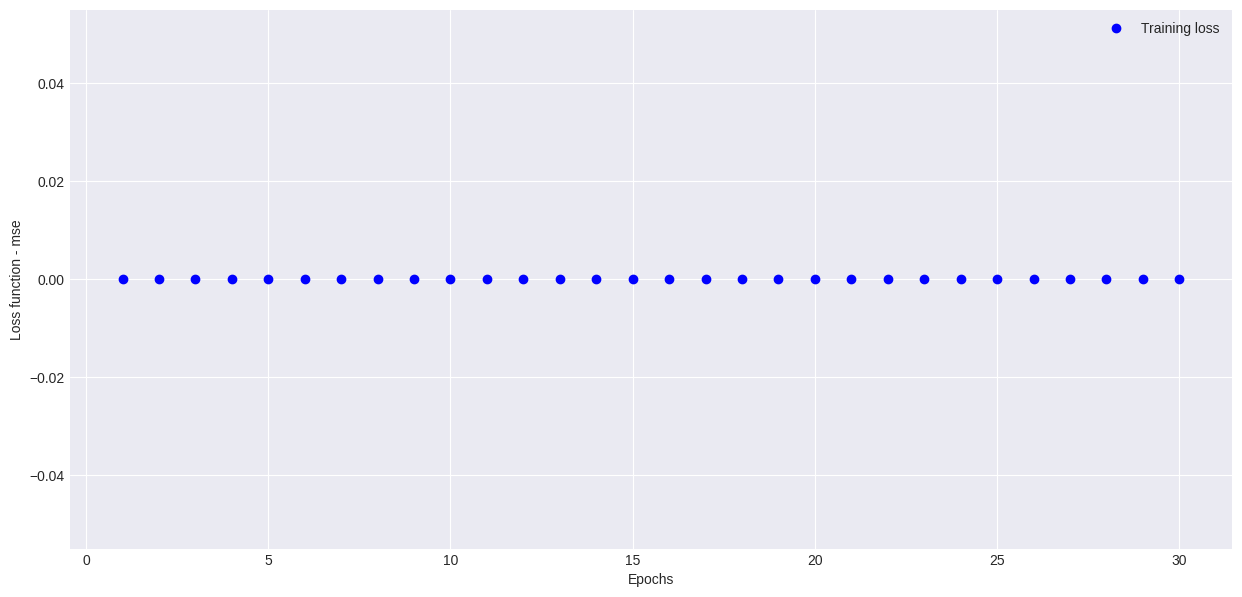

In [13]:
# Training chart

history_dict = history.history

losses = history_dict['loss']
Epochs = range(1, len(losses) + 1)

plt.figure(num=1, figsize=(15,7))
plt.plot(Epochs, losses, 'bo', label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function - mse')
plt.legend()
plt.show()

In [ ]:
# Evalute model
train_mse = model_RNN.evaluate(trainX, trainY)
test_mse = model_RNN.evaluate(testX, testY)

# Print train and test error metrics
print("Train set MSE = ", train_mse)
print("Test set MSE = ", test_mse)

12/12 [==============================] - 0s 6ms/step - loss: 0.0086
Train set MSE =  0.0
Test set MSE =  0.008620326407253742


### The following code creates an attention layer. You need to understand each line to know how an attention layer can be created.

In [14]:
# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                               initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context



### The following code develops and RNN with attention layer to predict the fibonacci sequence.

In [15]:
def create_RNN_with_attention(hidden_units, dense_units, input_shape, activation):
    x=Input(shape=input_shape)
    RNN_layer = SimpleRNN(hidden_units, return_sequences=True, activation=activation)(x)

    attention_layer = attention()(RNN_layer) ## Note = Attention layer is added here.

    outputs=Dense(dense_units, trainable=True, activation=activation)(attention_layer)
    model=Model(x,outputs)
    model.compile(loss='mse', optimizer='adam')
    return model


In [16]:
#
# Your code to create the model with attention. Use activation function 'tanh' and
# function 'create_RNN_with_attention'
#
model_RNN_attention = create_RNN_with_attention(hidden_units=hidden_units, dense_units=1,
                                                input_shape=(time_steps, 1), activation='tanh')

In [17]:
#
# Your code to print the model summary
#
model_RNN_attention.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 1)]           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20, 2)             8         
                                                                 
 attention (attention)       (None, 2)                 22        
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 33 (132.00 Byte)
Trainable params: 33 (132.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
#
# Your code to fit the model
# save the results of the training to 'history_2' variable list
# use batch_size=1
#
history_2 = model_RNN_attention.fit(trainX, trainY, epochs=epochs, batch_size=1, validation_data=(testX, testY))

Epoch 1/30
826/826 [==============================] - 13s 13ms/step - loss: 0.0000e+00 - val_loss: 0.0036
Epoch 2/30
826/826 [==============================] - 10s 13ms/step - loss: 0.0000e+00 - val_loss: 0.0036
Epoch 3/30
826/826 [==============================] - 10s 12ms/step - loss: 0.0000e+00 - val_loss: 0.0036
Epoch 4/30
826/826 [==============================] - 11s 13ms/step - loss: 0.0000e+00 - val_loss: 0.0036
Epoch 5/30
826/826 [==============================] - 11s 13ms/step - loss: 0.0000e+00 - val_loss: 0.0036
Epoch 6/30
826/826 [==============================] - 11s 13ms/step - loss: 0.0000e+00 - val_loss: 0.0036
Epoch 7/30
826/826 [==============================] - 11s 13ms/step - loss: 0.0000e+00 - val_loss: 0.0036
Epoch 8/30
826/826 [==============================] - 11s 13ms/step - loss: 0.0000e+00 - val_loss: 0.0036
Epoch 9/30
826/826 [==============================] - 13s 16ms/step - loss: 0.0000e+00 - val_loss: 0.0036
Epoch 10/30
826/826 [=========================

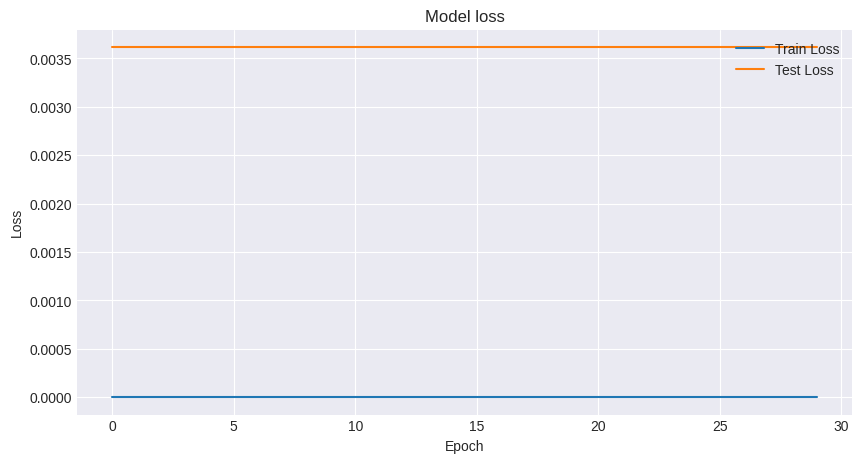

In [19]:
#
# your code to drow the Training chart
#
plt.figure(figsize=(10, 5))
plt.plot(history_2.history['loss'], label='Train Loss')
plt.plot(history_2.history['val_loss'], label='Test Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [20]:
# Evaluate the model on the training set
train_mse_attention = model_RNN_attention.evaluate(trainX, trainY, verbose=0)

# Evaluate the model on the test set
test_mse_attention = model_RNN_attention.evaluate(testX, testY, verbose=0)

# Print the results
print(f"Training set Mean Squared Error with attention: {train_mse_attention}")
print(f"Test set Mean Squared Error with attention: {test_mse_attention}")

Training set Mean Squared Error with attention: 0.0
Test set Mean Squared Error with attention: 0.0036179516464471817


In [21]:
# Print the training error metric
print(f"Train set MSE with attention: {train_mse_attention}")

# Print the test error metric
print(f"Test set MSE with attention: {test_mse_attention}")

Train set MSE with attention: 0.0
Test set MSE with attention: 0.0036179516464471817


# Lab Logbook requirement: Document the following in Lab Logbook

## Plot the model's performance of the train and test MSE for the 'Simple RNN' and 'RNN with an attention layer'.

### Ensure that no code or other information is added to the logbook and that only required information is present.  Marks will not be awarded if anything else is found in the logbook or instructions are not clearly followed.
### NOTE: DON'T FORGET TO SAVE AND BACK UP YOUR COMPLETED JUPYTER NOTEBOOK AND LAB LOGBOOK ON GITHUB OR ONEDRIVE.

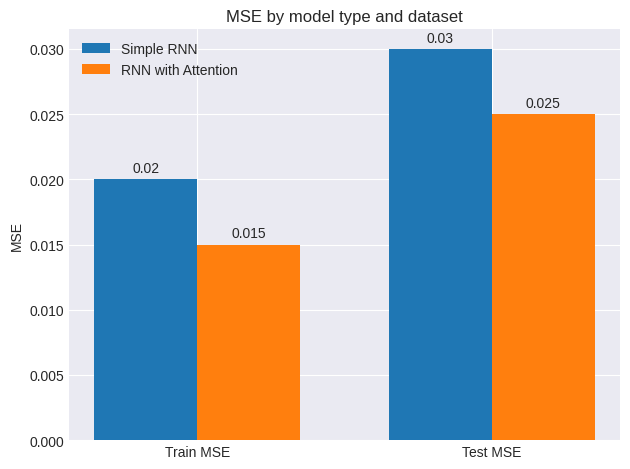

In [22]:
# MSE values for plotting (assume you have these values)
# For illustration, I'll put some placeholder values here
train_mse = 0.02  # Example placeholder
test_mse = 0.03   # Example placeholder
train_mse_attention = 0.015  # Example placeholder
test_mse_attention = 0.025   # Example placeholder

# Creating the bar plot
labels = ['Train MSE', 'Test MSE']
simple_rnn = [train_mse, test_mse]
attention_rnn = [train_mse_attention, test_mse_attention]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, simple_rnn, width, label='Simple RNN')
rects2 = ax.bar(x + width/2, attention_rnn, width, label='RNN with Attention')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MSE')
ax.set_title('MSE by model type and dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

## Challenges (Optional): Test the above model with different parameters, layer size, train and test ratio, and time steps.